In [1]:
%matplotlib inline
from datetime import datetime, date  # working with date and time
import matplotlib.pyplot as plt      # graphing
import numpy as np                   # math
import os                            # useful for handling filenames etc.
import pandas as pd                  # manipulating data
from scipy.stats import pearsonr     # calculates the Pearson correlation coefficient and p-value
import seaborn as sns                # makes matplotlib beautiful
sns.set_style('darkgrid')
import weather_station_utils as wsu  # helper functions for WeatherUnderground data

import matplotlib as mpl             # control formatting
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = 'semibold'

# interactive graphs
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import DatetimeTickFormatter
output_notebook()

Loading BokehJS ...

# Goleta Fire 2018
In the week of June 24, 2018, there was a fire in the Santa Barbara/Goleta region in Southern California. Ash was blown by the wind all the way to Berkeley. In this section, we will try to 
1. find spikes in the levels of particulate matter detected by our sensors, and, if we do find some, then we will
2. look for correlations between particulate matter levels and radiation levels, to see if the fire and smoke release and carry radioactive material in greater concentrations than normal.

First, let's get the binned data from the DoseNet sensors at Etcheverry Roof. Let's choose an interval of half a day (43200 seconds) for now. We will try other binning intervals later.

In [2]:
DATA_DIR = 'binned_data_10_days'
INTERVAL = 10800
dosenet_data = wsu.get_all_binned(interval=INTERVAL, data_dir=DATA_DIR, location='mira')
dosenet_data

,co2,humidity,temperature,pressure,pgradiation,pm1,pm25,unix_time,pm10
0,0.0,72.984444,15.888056,995.494444,1.911111,6.627500,10.525556,1530255601,14.983056
1,0.0,75.268919,15.345405,995.597297,2.055556,7.122500,11.071389,1530266401,15.822222
2,0.0,73.535135,16.661622,995.847568,1.700000,5.984444,9.436111,1530277201,13.463333
3,0.0,65.364324,21.233514,995.968378,1.733333,6.456111,10.079167,1530288001,14.388056
4,0.0,45.755135,25.516757,995.334054,2.027778,2.593056,4.801111,1530298801,6.931389
5,0.0,34.848611,27.657222,994.149444,2.969231,1.068333,2.599167,1530309601,3.822500
6,0.0,37.908333,27.755833,993.008333,NaN,2.974722,5.411944,1530320401,7.860556
7,0.0,53.354722,21.696389,993.742222,2.029412,5.231389,8.671667,1530331201,12.557778
8,0.0,62.940833,18.357222,993.679722,1.872222,4.519444,7.565278,1530342001,10.915833
9,0.0,68.175000,16.200000,993.881111,1.911111,3.617222,5.979722,1530352801,8.643056


Next, let's download data from the WeatherUnderground website. Let's get data from the [Berkeley Claremont station](https://www.wunderground.com/personal-weather-station/dashboard?ID=KCABERKE105) because it is close to Etcheverry Hall (the location of the DoseNet sensor) and because its data is quite reliable.

In [3]:
print(date.fromtimestamp(dosenet_data.iloc[0]['unix_time']))
print(date.fromtimestamp(dosenet_data.loc[dosenet_data.shape[0] - 1, 'unix_time']))

2018-06-29
2018-07-10


In [4]:
LOCATION_ID = 'KCAORIND23'

start_time = date.fromtimestamp(dosenet_data.iloc[0]['unix_time'])
end_time = date.fromtimestamp(dosenet_data.loc[dosenet_data.shape[0] - 1, 'unix_time'])

ws_data = wsu.get_ws_data_by_time(start_time, end_time)
ws_data

,Dewpoint,HourlyPrecipIn,Humidity,Pressure,SolarRadiationWatts/m^2,Temperature,Time,WindDirection,WindDirectionDegrees,WindSpeedGustMPH,WindSpeedMPH,dailyrainin
0,11.222222,0.0,93.0,1006.430739,0.0,12.277778,1530255898,ESE,102.0,0.0,0.0,0.0
1,11.111111,0.0,92.0,1006.430739,0.0,12.277778,1530256186,SE,131.0,0.0,0.0,0.0
2,10.888889,0.0,91.0,1006.430739,0.0,12.277778,1530256490,ESE,107.0,0.0,0.0,0.0
3,10.888889,0.0,91.0,1006.430739,0.0,12.277778,1530256794,SE,132.0,0.0,0.0,0.0
4,10.722222,0.0,90.0,1006.092102,0.0,12.277778,1530257098,East,86.0,0.0,0.0,0.0
5,11.000000,0.0,91.0,1006.430739,0.0,12.388889,1530257386,ESE,110.0,0.0,0.0,0.0
6,11.000000,0.0,91.0,1006.430739,0.0,12.388889,1530257690,ESE,114.0,0.0,0.0,0.0
7,10.777778,0.0,90.0,1006.430739,0.0,12.388889,1530257994,ESE,109.0,0.0,0.0,0.0
8,11.222222,0.0,92.0,1006.430739,0.0,12.388889,1530258298,East,88.0,0.0,0.0,0.0
9,11.277778,0.0,93.0,1006.430739,0.0,12.388889,1530258586,SSW,205.0,0.0,0.0,0.0


Then, we will bin the data. Note that it involves modifying the script `multi_bin.py` and running it from terminal as follows:
```
python multi_bin.py
```
This will automatically do all the binnings for us.

In [5]:
# Let's see the column headers
ws_data.columns.values.tolist()

['Dewpoint',
 'HourlyPrecipIn',
 'Humidity',
 'Pressure',
 'SolarRadiationWatts/m^2',
 'Temperature',
 'Time',
 'WindDirection',
 'WindDirectionDegrees',
 'WindSpeedGustMPH',
 'WindSpeedMPH',
 'dailyrainin']

In [6]:
# first, save the DataFrame as a `.csv` file
# before saving, we need to rename the column `Time` to `deviceTime_unix`
header = ws_data.columns.values.tolist()
header[6] = 'deviceTime_unix'
# commented out this line because we don't want to do this every time we rerun the notebook
ws_data.to_csv('wunderground_data/data_fire_mira.csv', na_rep='nan', index=False, header=header)

# next, bin the wind direction data because that is what we are interested in
# make sure to modify `multi_bin.py` appropriately and run it from terminal

In [7]:
winddir_data_interval = pd.read_csv(f'binned_data_10_days/ws_data_WindDirectionDegrees_{INTERVAL}.csv',
                                header=0, names=['unix_time', 'WindDirection'], usecols=[1])
windspd_data_interval = pd.read_csv(f'binned_data_10_days/ws_data_WindSpeedMPH_{INTERVAL}.csv',
                                header=0, names=['unix_time', 'WindSpeedMPH'], usecols=[1])
dosenet_and_ws = pd.concat([dosenet_data, winddir_data_interval, windspd_data_interval], axis=1)
dosenet_and_ws

,co2,humidity,temperature,pressure,pgradiation,pm1,pm25,unix_time,pm10,WindDirection,WindSpeedMPH
0,0.0,72.984444,15.888056,995.494444,1.911111,6.627500,10.525556,1530255601,14.983056,105.916667,0.130556
1,0.0,75.268919,15.345405,995.597297,2.055556,7.122500,11.071389,1530266401,15.822222,96.500000,0.005556
2,0.0,73.535135,16.661622,995.847568,1.700000,5.984444,9.436111,1530277201,13.463333,132.666667,0.000000
3,0.0,65.364324,21.233514,995.968378,1.733333,6.456111,10.079167,1530288001,14.388056,131.750000,0.025000
4,0.0,45.755135,25.516757,995.334054,2.027778,2.593056,4.801111,1530298801,6.931389,154.250000,0.213889
5,0.0,34.848611,27.657222,994.149444,2.969231,1.068333,2.599167,1530309601,3.822500,168.750000,0.000000
6,0.0,37.908333,27.755833,993.008333,NaN,2.974722,5.411944,1530320401,7.860556,150.805556,0.011111
7,0.0,53.354722,21.696389,993.742222,2.029412,5.231389,8.671667,1530331201,12.557778,108.083333,0.000000
8,0.0,62.940833,18.357222,993.679722,1.872222,4.519444,7.565278,1530342001,10.915833,100.416667,0.000000
9,0.0,68.175000,16.200000,993.881111,1.911111,3.617222,5.979722,1530352801,8.643056,91.777778,0.000000


In [8]:
dosenet_and_ws.dropna(axis=0, how='any', inplace=True)
dosenet_and_ws

,co2,humidity,temperature,pressure,pgradiation,pm1,pm25,unix_time,pm10,WindDirection,WindSpeedMPH
0,0.0,72.984444,15.888056,995.494444,1.911111,6.627500,10.525556,1530255601,14.983056,105.916667,0.130556
1,0.0,75.268919,15.345405,995.597297,2.055556,7.122500,11.071389,1530266401,15.822222,96.500000,0.005556
2,0.0,73.535135,16.661622,995.847568,1.700000,5.984444,9.436111,1530277201,13.463333,132.666667,0.000000
3,0.0,65.364324,21.233514,995.968378,1.733333,6.456111,10.079167,1530288001,14.388056,131.750000,0.025000
4,0.0,45.755135,25.516757,995.334054,2.027778,2.593056,4.801111,1530298801,6.931389,154.250000,0.213889
5,0.0,34.848611,27.657222,994.149444,2.969231,1.068333,2.599167,1530309601,3.822500,168.750000,0.000000
7,0.0,53.354722,21.696389,993.742222,2.029412,5.231389,8.671667,1530331201,12.557778,108.083333,0.000000
8,0.0,62.940833,18.357222,993.679722,1.872222,4.519444,7.565278,1530342001,10.915833,100.416667,0.000000
9,0.0,68.175000,16.200000,993.881111,1.911111,3.617222,5.979722,1530352801,8.643056,91.777778,0.000000
10,0.0,66.295000,17.854722,994.806667,1.838889,3.915000,6.420556,1530363601,9.095278,95.888889,0.000000


Now the big moment! We finally get to make a beautiful plot that will (or will not?) reveal correlations between wind direction and particulate matter levels, and radiation.

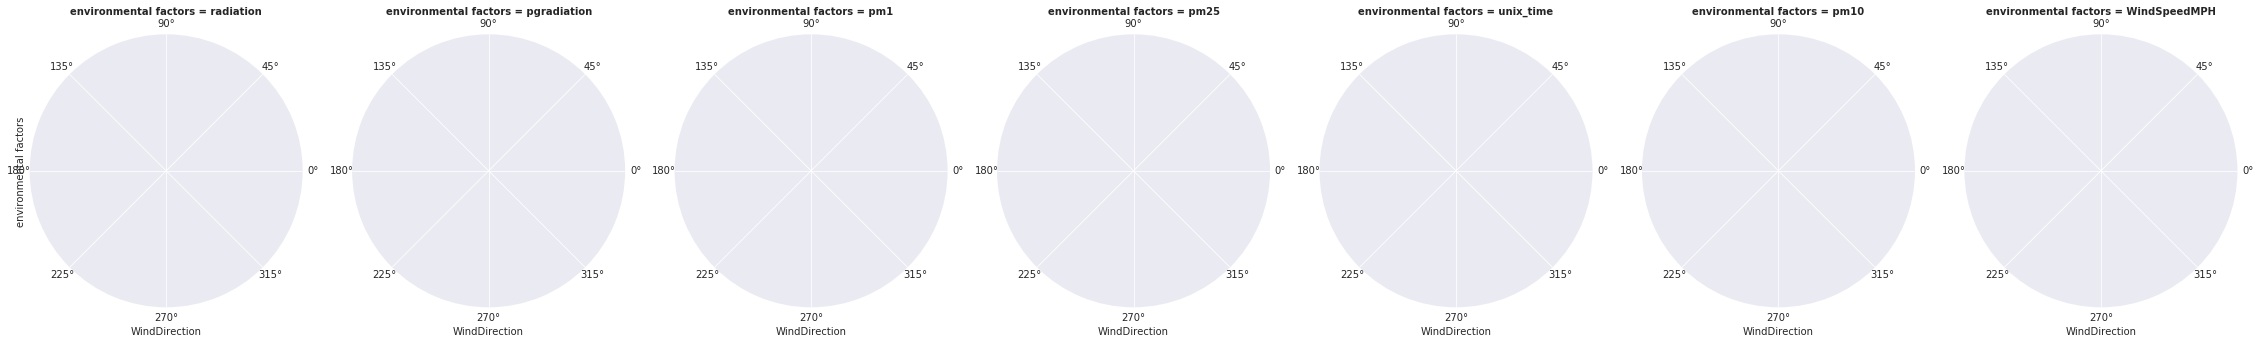

In [11]:
# FAIL!!!

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='polar')
# c = ax.scatter(dosenet_and_ws.WindDirection, dosenet_and_ws.WindSpeedMPH,
#             dosenet_and_ws.WindDirection, dosenet_and_ws.pm1,
#             dosenet_and_ws.WindDirection, dosenet_and_ws.pm25,
#             dosenet_and_ws.WindDirection, dosenet_and_ws.radiation)

to_be_plotted = pd.DataFrame(data=pd.concat([dosenet_and_ws['radiation'], dosenet_and_ws.loc[:, 'pgradiation':'WindSpeedMPH']], axis=1))
to_be_plotted = pd.melt(to_be_plotted, id_vars=['WindDirection'], 
                        var_name='environmental factors', value_name='values')

g = sns.FacetGrid(to_be_plotted, col='environmental factors', hue='environmental factors',
                  subplot_kws=dict(projection='polar'), size=4.5,
                  sharex=True, sharey=False, despine=False)

g.map(plt.scatter, 'WindDirection', 'environmental factors')

The following graph shows $CO_2$ concentration plotted against wind direction. The size of the blobs corresponds to wind speed (so if the size is small/wind speed is slow, you don't need to pay as much attention to the data point). The color corresponds to PM1.0 concentration in the air. It should, given enough wind, correspond roughly with $CO_2$ concentration.

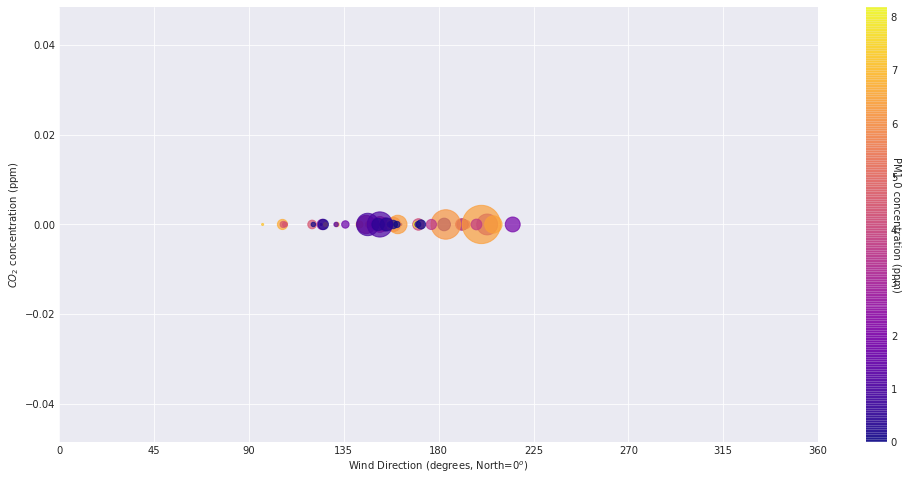

In [9]:
plt.figure(figsize=(17, 8))
plt.scatter(
    dosenet_and_ws['WindDirection'], dosenet_and_ws['co2'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pgradiation'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pm1'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pm25'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['WindSpeedMPH']
    c=dosenet_and_ws['pm1'], s=dosenet_and_ws['WindSpeedMPH']*800,
    cmap='plasma', alpha=0.7
)
cbar = plt.colorbar()
cbar.set_label('PM1.0 concentration (ppm)', rotation=270)
plt.xlabel('Wind Direction (degrees, North=$0^o$)')
plt.ylabel('$CO_2$ concentration (ppm)')
plt.xlim(left=0, right=360)
plt.xticks([45 * i for i in range(9)])
plt.show()

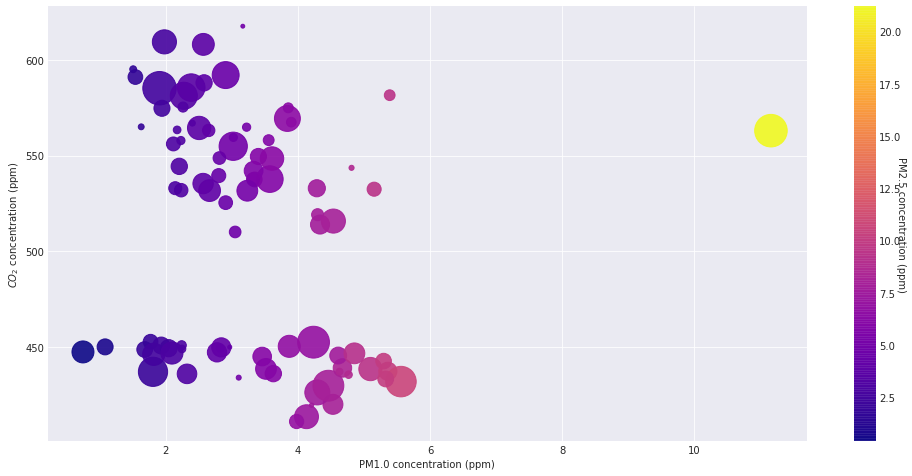

In [27]:
plt.figure(figsize=(17, 8))
plt.scatter(
    dosenet_and_ws['pm1'], dosenet_and_ws['co2'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pgradiation'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pm1'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['pm25'],
#     dosenet_and_ws['WindDirection'], dosenet_and_ws['WindSpeedMPH']
    c=dosenet_and_ws['pm25'],
    s=100*abs(dosenet_and_ws['radiation'] - (sum(dosenet_and_ws['radiation'])/len(dosenet_and_ws['radiation']))),
    cmap='plasma', alpha=0.9
)
cbar = plt.colorbar()
cbar.set_label('PM2.5 concentration (ppm)', rotation=270)
plt.xlabel('PM1.0 concentration (ppm)')
plt.ylabel('$CO_2$ concentration (ppm)')
# plt.xlim(left=0, right=360)
# plt.xticks([45 * i for i in range(9)])
plt.show()

Text(0.5,1,'$CO_2$ vs. PM1.0 (r=-0.18, p=0.09)')

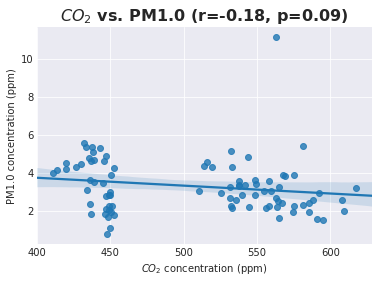

In [14]:
sns.regplot('co2', 'pm1', data=dosenet_and_ws)
plt.xlabel('$CO_2$ concentration (ppm)')
plt.ylabel('PM1.0 concentration (ppm)')
r, p = pearsonr(dosenet_and_ws['co2'], dosenet_and_ws['pm1'])
plt.title(f'$CO_2$ vs. PM1.0 (r={r:.2f}, p={p:.2f})')

Text(0.5,1,'$CO_2$ vs. PM2.5 (r=-0.19, p=0.07)')

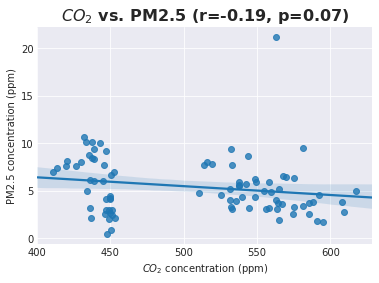

In [15]:
sns.regplot('co2', 'pm25', data=dosenet_and_ws)
plt.xlabel('$CO_2$ concentration (ppm)')
plt.ylabel('PM2.5 concentration (ppm)')
r, p = pearsonr(dosenet_and_ws['co2'], dosenet_and_ws['pm25'])
plt.title(f'$CO_2$ vs. PM2.5 (r={r:.2f}, p={p:.2f})')

Text(0.5,1,'PM1.0 vs. PM2.5 (r=1.00, p=0.00)')

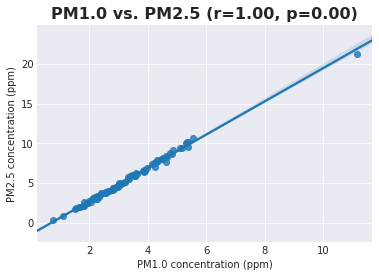

In [16]:
sns.regplot('pm1', 'pm25', data=dosenet_and_ws)
plt.xlabel('PM1.0 concentration (ppm)')
plt.ylabel('PM2.5 concentration (ppm)')
r, p = pearsonr(dosenet_and_ws['pm1'], dosenet_and_ws['pm25'])
plt.title(f'PM1.0 vs. PM2.5 (r={r:.2f}, p={p:.2f})')

Text(0.5,1,'PM2.5 vs. PM10 (r=0.96, p=0.00)')

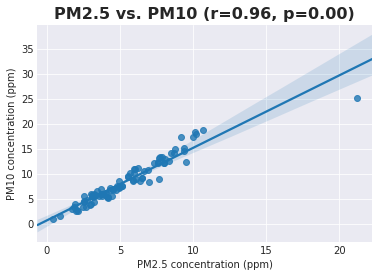

In [17]:
sns.regplot('pm25', 'pm10', data=dosenet_and_ws)
plt.xlabel('PM2.5 concentration (ppm)')
plt.ylabel('PM10 concentration (ppm)')
r, p = pearsonr(dosenet_and_ws['pm10'], dosenet_and_ws['pm25'])
plt.title(f'PM2.5 vs. PM10 (r={r:.2f}, p={p:.2f})')

Text(0.5,1,'$CO_2$ vs. PM10 (r=-0.22, p=0.04)')

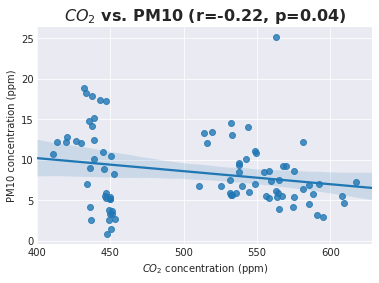

In [18]:
sns.regplot('co2', 'pm10', data=dosenet_and_ws)
plt.xlabel('$CO_2$ concentration (ppm)')
plt.ylabel('PM10 concentration (ppm)')
r, p = pearsonr(dosenet_and_ws['co2'], dosenet_and_ws['pm10'])
plt.title(f'$CO_2$ vs. PM10 (r={r:.2f}, p={p:.2f})')